In [1]:
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# CHANGE THIS if your folder name is different
SOURCE_PATH = '/content/dataset'

# Destination for the split data
DEST_DIR = '/content/processed_data'

# Clean up previous runs if they exist
if os.path.exists(DEST_DIR):
    shutil.rmtree(DEST_DIR)

# Verify source exists
if not os.path.exists(SOURCE_PATH):
    print(f"❌ ERROR: Could not find '{SOURCE_PATH}'.")
    print("Current folders in content:", os.listdir('content'))
else:
    print(f"✅ Found source data at: {SOURCE_PATH}")

✅ Found source data at: /content/dataset


In [3]:
print("\n--- Splitting Data (80% Train, 20% Test) ---")

CLASSES = ['plain', 'potholes']
SPLIT_RATIO = 0.8  # 80% Training

# Create destination folders
for split in ['train', 'test']:
    for category in CLASSES:
        os.makedirs(os.path.join(DEST_DIR, split, category), exist_ok=True)

# Move files
total_images = 0
for category in CLASSES:
    src_folder = os.path.join(SOURCE_PATH, category)

    # Check if the folder actually exists
    if not os.path.exists(src_folder):
        print(f"⚠️ ERROR: Folder '{category}' not found inside {SOURCE_PATH}")
        continue

    # Get all images
    files = [f for f in os.listdir(src_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    random.shuffle(files) # Shuffle to ensure random split

    # Calculate split
    train_count = int(len(files) * SPLIT_RATIO)
    train_files = files[:train_count]
    test_files = files[train_count:]

    # Copy to Train
    for f in train_files:
        shutil.copy(os.path.join(src_folder, f), os.path.join(DEST_DIR, 'train', category, f))

    # Copy to Test
    for f in test_files:
        shutil.copy(os.path.join(src_folder, f), os.path.join(DEST_DIR, 'test', category, f))

    print(f"✅ {category.upper()}: {len(train_files)} Train, {len(test_files)} Test")
    total_images += len(files)


--- Splitting Data (80% Train, 20% Test) ---
✅ PLAIN: 278 Train, 70 Test
✅ POTHOLES: 291 Train, 73 Test


In [4]:
if total_images == 0:
    print("❌ STOPPING: No images were found. Check your folder paths!")
else:
    print(f"Total Images Processed: {total_images}")

    # ==========================================
    # 3. DATA GENERATORS
    # ==========================================
    TRAIN_DIR = os.path.join(DEST_DIR, 'train')
    TEST_DIR = os.path.join(DEST_DIR, 'test')

    # Train Generator (With Augmentation)
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range=20,
        horizontal_flip=True,
        validation_split=0.2 # Use 20% of TRAIN data for validation
    )

    print("\n--- Loading Generators ---")
    train_generator = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary',
        subset='training'
    )

    val_generator = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary',
        subset='validation'
    )

    # Test Generator (Raw data for final report)
    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    test_generator = test_datagen.flow_from_directory(
        TEST_DIR,
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary',
        shuffle=False # CRITICAL
    )

Total Images Processed: 712

--- Loading Generators ---
Found 456 images belonging to 2 classes.
Found 113 images belonging to 2 classes.
Found 143 images belonging to 2 classes.


In [5]:
print("\n--- Building MobileNetV2 ---")
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

print("🚀 Starting Training...")
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    verbose=1
)

model.save('pothole_detector_final.h5')


--- Building MobileNetV2 ---
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
🚀 Starting Training...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.5647 - loss: 0.7619 - val_accuracy: 0.7522 - val_loss: 0.5078
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 917ms/step - accuracy: 0.7541 - loss: 0.5072 - val_accuracy: 0.8761 - val_loss: 0.3586
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 892ms/step - accuracy: 0.8740 - loss: 0.3720 - val_accuracy: 0.9292 - val_loss: 0.2909
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 904ms/step - accuracy: 0.9341 - loss: 0.2654 - val_accuracy: 0.9292 - val_loss: 0.2405
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 849ms/step - accuracy: 0.9122 - loss: 0.2678 - val_accuracy: 0.9204 - val_loss: 0.2371
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 881ms/step - accuracy: 0.9585 - loss: 0.1841 - val_accuracy: 0.9292 - val_loss: 0.1943
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 843ms/step - accuracy: 0.9495 - loss: 0.1699 - val_accuracy: 0.9381 - val_loss: 0.1949
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 895ms/step - accuracy: 0.9383 - loss: 0.1853 - val_accurac


GENERATING FINAL REPORT (TEST DATA)
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step

✅ FINAL TEST ACCURACY: 93.71%

--- Detailed Classification Report ---
              precision    recall  f1-score   support

       plain       0.94      0.93      0.94        70
    potholes       0.93      0.95      0.94        73

    accuracy                           0.94       143
   macro avg       0.94      0.94      0.94       143
weighted avg       0.94      0.94      0.94       143

✅ Saved confusion_matrix.png


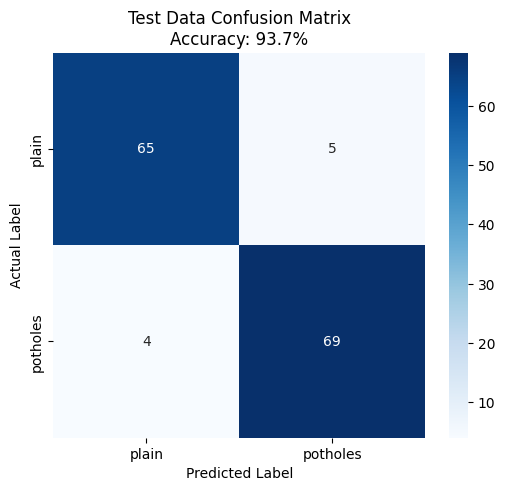

In [6]:
print("\n" + "="*40)
print("GENERATING FINAL REPORT (TEST DATA)")
print("="*40)

# Predict
predictions_prob = model.predict(test_generator, verbose=1)
predictions = (predictions_prob > 0.5).astype(int)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Metrics
acc = np.mean(predictions.flatten() == true_classes) * 100
print(f"\n✅ FINAL TEST ACCURACY: {acc:.2f}%")

print("\n--- Detailed Classification Report ---")
print(classification_report(true_classes, predictions, target_names=class_labels))

# Plot
plt.figure(figsize=(6, 5))
cm = confusion_matrix(true_classes, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title(f'Test Data Confusion Matrix\nAccuracy: {acc:.1f}%')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

plt.savefig('confusion_matrix.png', bbox_inches='tight')
print("✅ Saved confusion_matrix.png")

plt.show()


Upload an image to test (JPG/PNG)...


Saving highway.jpeg to highway.jpeg


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


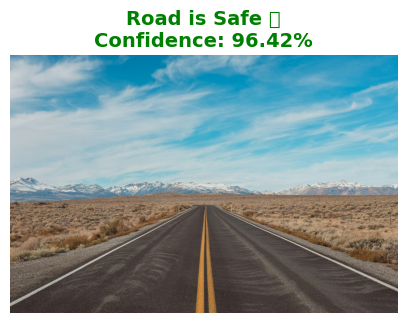

🗑️ Image 'highway.jpeg' has been deleted from memory.


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab import files
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# 1. LOAD MODEL (Only needs to run once)
if 'model' not in locals(): # Check if model is already loaded to save time
    model_path = 'pothole_detector_final.h5'
    print(f"Loading {model_path}...")
    try:
        model = load_model(model_path)
        print("✅ Model loaded!")
    except:
        print("❌ Model not found. Check the filename.")

# 2. UPLOAD
print("\nUpload an image to test (JPG/PNG)...")
uploaded = files.upload()

# 3. PREDICT, SHOW, & DISPOSE
for fn in uploaded.keys():
    try:
        # --- A. PREDICT ---
        # Load directly from the uploaded file
        img = image.load_img(fn, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        prediction_prob = model.predict(x, verbose=0)[0][0]

        # --- B. DISPLAY ---
        if prediction_prob > 0.5:
            label = "POTHOLE DETECTED 🚨"
            confidence = prediction_prob * 100
            color = 'red'
        else:
            label = "Road is Safe ✅"
            confidence = (1 - prediction_prob) * 100
            color = 'green'

        plt.figure(figsize=(5, 5))
        plt.imshow(image.load_img(fn)) # Show the image
        plt.axis('off')
        plt.title(f"{label}\nConfidence: {confidence:.2f}%", color=color, fontsize=14, fontweight='bold')
        plt.show()

    finally:
        # --- C. DISPOSE ---
        if os.path.exists(fn):
            os.remove(fn)
            print(f"🗑️ Image '{fn}' has been deleted from memory.")